In [16]:
from core import *
from imports import *
from db_core import *

# using custom config class and yml file

In [17]:
###################################################
# importing os.path module  
import os.path 
  
#read from .yml file

from core import Config
config = Config.data_path()
arr = Config.get_key('hyperparameter')
df = pd.DataFrame(arr, columns=['seed','ntrees','mtries','max_depth', 'sample_rate'])
n,m = df.shape

# Read data from database 
# Queries defined in .yml file

In [6]:
df1 = get_dataframe('sql_qry1')
df2 = get_dataframe('sql_qry2')
df3 = get_dataframe('sql_qry3')

# Implementation of Semi-supervised Isolation Forest using h2o framework

# Data preprocessing  BEGIN

In [22]:
pmid_env = df1   
pmid_demog_n = df2
zip_service_n = df3
zip_service_n.zip_service = zip_service_n.zip_service.astype(str)

# Merge with other tables and further preProcessing 

In [1]:
evlabelled_data = pd.merge(pmid_env,pmid_demog_n,how='inner', on=['contract_account'])
# Convert string data to uppercase
evlabelled_data= evlabelled_data.applymap(lambda s:s.upper() if type(s) == str else s)
evlabelled_data.zip_service = evlabelled_data.zip_service.astype(int)
zip_service_n.zip_service = zip_service_n.zip_service.astype(int)
evlabelled_data = pd.merge(evlabelled_data,zip_service_n, how='left', left_on="zip_service", right_on="zip_service")


# Use case of Outer join to filter a specific type of class label and get the other class

In [ ]:
non_ev_data = pd.merge(pmid_demog_n,pmid_env, how='outer', indicator=True)
non_ev_data = non_ev_data[non_ev_data['_merge'] == 'left_only']
# convert string to upper case
non_ev_data.apply(lambda x: x.astype(str).str.upper())
# take care of np.nan and 'nan'  before int conversion
non_ev_data['zip_service'] = non_ev_data['zip_service'].replace(np.nan,0)
# Do this to convert non numeric 'nan'
non_ev_data['zip_service'] = non_ev_data.apply(lambda s: s['zip_service'] if s['zip_service'] != 'nan' else 0, axis=1 )
# convert to integer before merge
non_ev_data.zip_service = non_ev_data.zip_service.astype(int)
non_ev_data = pd.merge(non_ev_data,zip_service_n,how='left', left_on="zip_service", right_on="zip_service")

# Helper Functions

In [28]:
def coerce_df_columns_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')

In [29]:
#Binning:
def quote(s):
    return "\"" + s + "\""
def binning(cut_points, labels=None): 
    colBin = {}
    for i in range(len(cut_points)): 
        label = labels[i]
        colBin[label] = cut_points[i]
    return colBin



def rangemap(row,rmap,label):
    if row[label] != 'UN':
       return rmap[row[label]]
    return row[label]

def rangeBinning(pcaEvdata,labels):
    for ll in labels:
        uniquerangeitems = pcaEvdata[ll].unique()
        cut_points = [ s+1 for s in range(len(uniquerangeitems)) ]
        rmap = binning(cut_points, uniquerangeitems)
        pcaEvdata[ll] = pcaEvdata.apply(lambda x: rangemap(x,rmap,ll), axis=1)  
        
# Helper FN
def dataImputation(pcaEvdata,label):
    coerce_df_columns_to_numeric(pcaEvdata,[label])#'median_home_value'])
    tmpdf = pcaEvdata.groupby(['zip_service',label]).size().reset_index().groupby(['zip_service'],as_index=False)
    df_label = tmpdf.agg({label:"max"})
    maxval = label+'_'+'maxval'
    df_label.rename(columns = {label:maxval},inplace = True) 
    pcaEvdata = pd.merge(pcaEvdata,df_label,how='outer', on="zip_service")
    pcaEvdata[label] = pcaEvdata[label].replace(np.nan, pcaEvdata[maxval])
    pcaEvdata.drop([maxval],axis=1)

# Data Imputation: Avoid For loops , use dataframe for all calculations

In [30]:
#drop
pcaEvdata = evlabelled_data.drop(['rate_category', 'business_partner', 'economic_stability'], axis=1)
# convery object type to numeric
coerce_df_columns_to_numeric(pcaEvdata,['number_of_children','number_of_adults','residence_tenure','contract_account',
                                        'ebill','auto_pay','enrolled_arcadia','enrolled_care',
                                        'enrolled_ee','ev'])
pcaEvdata['net_worth'] = pcaEvdata.apply(lambda s: s['net_worth'] if s['net_worth'] != "UN" else s['median_home_value'], axis=1 )
pcaEvdata['median_home_value'] = pcaEvdata.apply(lambda s: s['median_home_value'] if s['median_home_value'] != "UN" else s['net_worth'], axis=1 )
# Features that requite binning
labels = ['net_worth','median_home_value','education_level','age_range','net_worth','income_range']
rangeBinning(pcaEvdata,labels)
# Use helper FN to apply the final custom logic to impute data
dataImputation(pcaEvdata,'median_home_value')
dataImputation(pcaEvdata,'net_worth')
#drop
pcanonEvdata = non_ev_data.drop(['rate_category', 'business_partner', 'economic_stability'], axis=1)
# fill UN net_worth with median_home_value
# fill UN median_home_value with net_worth
pcanonEvdata['median_home_value'] = pcanonEvdata.apply(lambda s: s['median_home_value'] if s['median_home_value'] != "UN" else s['net_worth'], axis=1 )
pcanonEvdata['net_worth'] = pcanonEvdata.apply(lambda s: s['net_worth'] if s['net_worth'] != "UN" else s['median_home_value'], axis=1 )
# Binning
rangeBinning(pcanonEvdata,labels)
# More NAN and UN values, replace them with mean at the END
pcanonEvdata['net_worth'] = pcanonEvdata.apply(lambda s: s['net_worth'] if s['net_worth'] != "UN" else 0, axis=1 )
pcanonEvdata['median_home_value'] = pcanonEvdata.apply(lambda s: s['median_home_value'] if s['median_home_value'] != "UN" else 0, axis=1 )
pcanonEvdata.median_home_value = pcanonEvdata.median_home_value.astype(int)
pcanonEvdata.net_worth = pcanonEvdata.net_worth.astype(int)
pcanonEvdata['median_home_value'].fillna((pcanonEvdata['median_home_value'].mean()), inplace=True)
pcanonEvdata['net_worth'].fillna((pcanonEvdata['net_worth'].mean()), inplace=True)

# Data PREPROCESSING ENDs *

# MODEL PREPARATION: Semi-Supervised Model

# Dataset

In [52]:
traindata_ev = pcaEvdata
traindata = pcanonEvdata
types = traindata.dtypes.iteritems()
# Important: Semi-supervised model requires a class label in all the dataset and h2o framework requires that
traindata['EV']=0 #on Unlabeled data
traindata_ev['EV']=1 # on Labeled data

# Initialize h2o

In [54]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 17 hours 23 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,8 months and 16 days !!!
H2O_cluster_name:,H2O_from_python_mmukherj_y1i2rd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,27.12 Gb
H2O_cluster_total_cores:,32
H2O_cluster_allowed_cores:,32
H2O_cluster_status:,"locked, healthy"


## Train and Test data split for semi-supervised model building
# training data creation is fundamentally different for semi-supervised.

In [62]:
#training data and test data split 90/10 split
train, test, _, _ = train_test_split(traindata,traindata,test_size=.1, random_state=42)
ev_train, ev_test, _, _ = train_test_split(traindata_ev, traindata_ev, test_size=.1, random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
train = train.append(ev_train).sample(frac=1).reset_index(drop=True)
test = test.append(ev_test).sample(frac=1).reset_index(drop=True)

In [63]:
#columns ignored in the isolation forest
cols = train.columns
minuscols=['contract_account','zip_service','ebill', 'health_concern', 'spp_wpp', 'enrolled_arcadia', \
           'enrolled_ee', 'state','auto_pay','bill_consolidator',\
          'enrolled_care','ev','_merge']
newcols = [e for e in cols if e not in minuscols]
#new_df with selected_columns
from core import select_columns # this is coming from core.py file
new_df = select_columns(train ,newcols)

# h2o dataFrame ( order is very important, do not change without validation)

In [66]:
type2 = Config.get_key('types2') # comes from evconfig.yml file
df = h2o.H2OFrame(new_df, column_types=type2[0]) # pandas dataframe needs to be converted to h2o frame

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [2]:
#check nan data

dff=df.fillna(method="forward", axis=0,maxlen=1)
#set column name in h2o dataframe using pandas dataframe column
dff.set_names(newcols)

# Get Hyper parameters and start isolation forest model building.

In [68]:
gs = GridSearch(Config.get_key('hyperparameter')) # It's defined in core.py file
gs.build_train_model(x=df.col_names[0:52], training_frame=dff)

isolationforest Model Build progress: |███████████████████████████████████| 100%
isolationforest Model Build progress: |███████████████████████████████████| 100%
Model Details
H2OIsolationForestEstimator :  Isolation Forest
Model Key:  IsolationForest_model_python_1608309029971_14


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,110.0,110.0,19095363.0,16.0,16.0,16.0,6691.0,19879.0,13842.428




ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: 14.987850841260512
Normalized Anomaly Score: 0.004545603609993716

Scoring History: 


,,timestamp,duration,number_of_trees,mean_tree_path_length,mean_anomaly_score
0,,2020-12-20 05:00:32,0.000 sec,0.0,NaN,NaN
1,,2020-12-20 05:00:33,0.813 sec,1.0,14.986843,0.001316
2,,2020-12-20 05:00:34,1.672 sec,2.0,14.985598,0.001694
3,,2020-12-20 05:00:35,2.375 sec,3.0,14.986163,0.002306
4,,2020-12-20 05:00:35,3.125 sec,4.0,14.987037,0.002161
5,,2020-12-20 05:00:36,3.844 sec,5.0,14.987000,0.002407
6,,2020-12-20 05:00:41,8.438 sec,12.0,14.988047,0.003118
7,,2020-12-20 05:00:45,12.547 sec,18.0,14.987578,0.004141
8,,2020-12-20 05:00:49,17.156 sec,25.0,14.988099,0.004076
9,,2020-12-20 05:00:54,21.313 sec,31.0,14.988066,0.004065



See the whole table with table.as_data_frame()
Model Details
H2OIsolationForestEstimator :  Isolation Forest
Model Key:  IsolationForest_model_python_1608309029971_15


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,90.0,90.0,10226972.0,15.0,15.0,15.0,4258.0,13171.0,9061.145




ModelMetricsAnomaly: isolationforest
** Reported on train data. **

Anomaly Score: 13.99413783097739
Normalized Anomaly Score: 0.0026646222829967547

Scoring History: 


,,timestamp,duration,number_of_trees,mean_tree_path_length,mean_anomaly_score
0,,2020-12-20 05:01:56,0.000 sec,0.0,NaN,NaN
1,,2020-12-20 05:01:57,0.703 sec,1.0,13.994275,0.000572
2,,2020-12-20 05:01:57,1.390 sec,2.0,13.994007,0.000856
3,,2020-12-20 05:01:58,1.953 sec,3.0,13.994017,0.001282
4,,2020-12-20 05:01:59,2.719 sec,4.0,13.993802,0.001653
5,,2020-12-20 05:01:59,3.344 sec,5.0,13.993663,0.001864
6,,2020-12-20 05:02:04,7.547 sec,12.0,13.994125,0.001602
7,,2020-12-20 05:02:08,11.765 sec,19.0,13.994138,0.001768
8,,2020-12-20 05:02:12,15.906 sec,26.0,13.994296,0.002089
9,,2020-12-20 05:02:16,20.047 sec,33.0,13.994336,0.002173


[, ]

# Validate Model using out of sample test data

In [3]:
dftest = select_columns(test ,newcols)
df_test = h2o.H2OFrame(dftest, column_types=type2[0]) # pandas dataframe needs to be converted into h2o dataframe
dff_test=df_test.fillna(method="forward", axis=0,maxlen=1)
dff_test.set_names(newcols)

In [70]:
#best model and fscore
isoforest, fscore = gs.optimal_model(df=dff_test)

isolationforest prediction progress: |████████████████████████████████████| 100%
isolationforest prediction progress: |████████████████████████████████████| 100%
index 1


# use optimal model to predict on validation set  

In [71]:
t = time.process_time()
predictions_test = isoforest.predict(dff_test)
elapsed_time = time.process_time() - t

isolationforest prediction progress: |████████████████████████████████████| 100%


In [72]:
quantile = 0.95
quantile_frame_test = predictions_test.quantile([quantile])
threshold_test = quantile_frame_test[0, "predictQuantiles"]
predictions_test["predicted_class"] = predictions_test["predict"] > threshold_test
predictions_test["class"] = dff_test['EV'] #h2o framework needs this 'EV' label setup for semi-supervised

# Confusion matrix and AUC curve on validation set

<IPython.core.display.Javascript object>


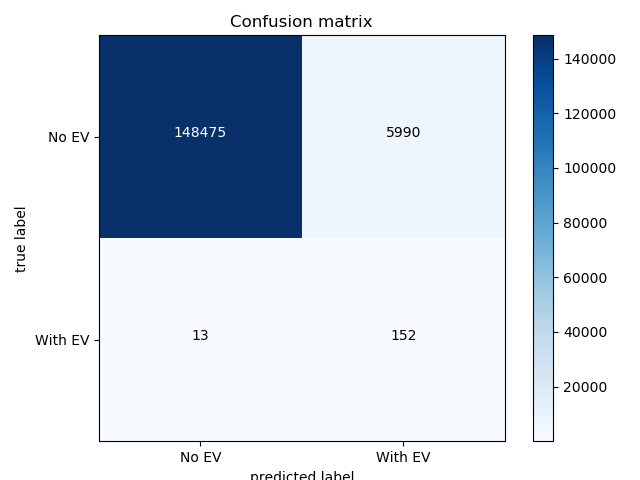

<IPython.core.display.Javascript object>


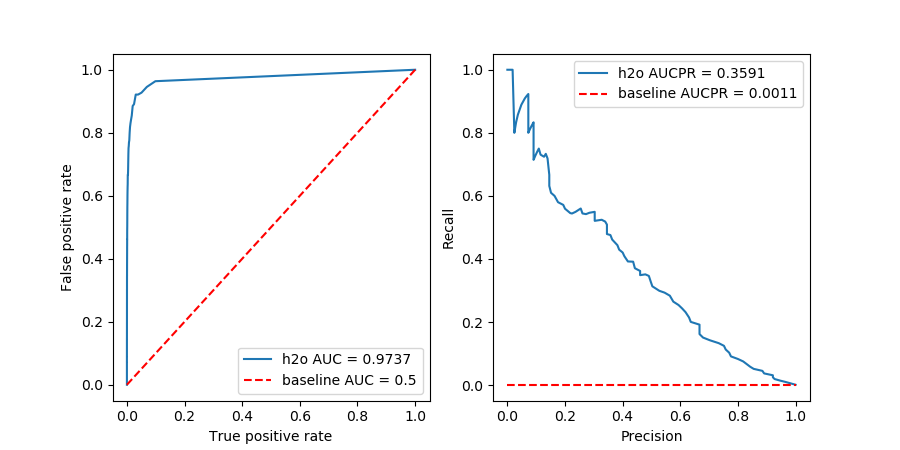

In [74]:
%matplotlib notebook

from core import plot_confusion_matrix,figure,prediction_summary

#On complete non-labeled data set
h2o_predictions_test = predictions_test.as_data_frame()

from sklearn.metrics import confusion_matrix,fbeta_score
cnf_matrix = confusion_matrix(h2o_predictions_test["class"], h2o_predictions_test["predicted_class"])
fscore = fbeta_score(y_pred=h2o_predictions_test["predicted_class"], y_true=h2o_predictions_test["class"],beta=2)
plot_confusion_matrix(cnf_matrix, classes=['No EV', 'With EV'], title='Confusion matrix')

figure()
axes = prediction_summary(
    h2o_predictions_test["class"], h2o_predictions_test["predict"], "h2o")

# Run Predict on all non labeled data

In [75]:
#columns ignored in the isolation forest due to a lot of missing values and other irrelevant features
cols_pred = traindata.columns
minus_pred_cols=['zip_service','ebill', 'health_concern', 'spp_wpp', 'enrolled_arcadia', \
           'enrolled_ee', 'state','auto_pay','bill_consolidator',\
          'enrolled_care','ev','_merge']
new_pred_cols = [ e for e in cols_pred if e not in minus_pred_cols]
dflabeled = select_columns(traindata, new_pred_cols)

In [77]:
type3 = Config.get_key('type3') # coming from evconfig.yml file
df_labeled1 = h2o.H2OFrame(dflabeled, column_types=type3[0])
df_labeled2 = df_labeled1.drop(['contract_account'])


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [79]:
filled_labeled=df_labeled2.fillna(method="forward", axis=0,maxlen=1)
filled_labeled.set_names(df_labeled2.columns)
t = time.process_time()
predictions_labeled = isoforest.predict(filled_labeled)
elapsed_time = time.process_time() - t

isolationforest prediction progress: |████████████████████████████████████| 100%


In [4]:
finalpred_df = df_labeled1[:-1].cbind(predictions_labeled[:1])
#convert h2o dataframe to pandas dataframe
finalpred = finalpred_df.as_data_frame()

# Study the Isolation Forest score and create probability buckets

In [103]:
finalpred['predict'] = finalpred['predict'] * 100
finalpred.loc[finalpred.predict > 100, 'predict'] = 100
# Add a new column to apply the above formula, so that you can compare before and after
finalpred['Probability_Score'] = finalpred.predict
# Apply the first formula( Probability between 80% to 100%)
finalpred.loc[(finalpred.predict >= 18) & \
              (finalpred.predict <= 38), 'Probability_Score'] = \
                100 - (finalpred.predict - 18)
# Apply the second formula( Probability between 60% to 80%)
finalpred.loc[(finalpred.predict > 38) & \
              (finalpred.predict <= 58), 'Probability_Score'] = \
                80 - (finalpred.predict - 38)
# Apply the third formula ( Probability less than 60% from right end)
finalpred.loc[(finalpred.predict > 58) & \
              (finalpred.predict <= 100), 'Probability_Score'] = \
                60 - (finalpred.predict - 58)
# Apply the fourth formula ( Probability less than 60% from left end)
finalpred.loc[(finalpred.predict >= 0) & \
              (finalpred.predict < 18), 'Probability_Score'] = \
                60 - (18 - finalpred.predict )
df_prob= finalpred[['Probability_Score']]
bins =  np.arange(0.0,100.0,10.0)
ind = np.digitize(df_prob['Probability_Score'],bins)
print(df_prob.groupby(ind).count().iloc[::-1])

# Pickle the file or insert the output into a database table